# Optimizing the design and operation of a DAC system under varying ambient conditions
This case study is based on a model developed here:
[Wiegner, Jan F., Alexa Grimm, Lukas Weimann, and Matteo Gazzani. "Optimal design and operation of solid sorbent direct air capture processes at varying ambient conditions." Industrial & Engineering Chemistry Research 61, no. 34 (2022): 12649-12667.
](https://pubs.acs.org/doi/10.1021/acs.iecr.2c00681)

We want to optimize the design and operation of a DAC with a target net negative emissions of 1000 t in the Netherlands. We therefore load climate data for a location in the Netherlands. We store the CO2 in a not further defined CO2 sink.

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [1]:
import adopt_net0 as adopt
import json

input_data_path = "./caseStudies/dac"
adopt.create_optimization_templates(path)

## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here) via some lines of code.
For the topology, we need to change the following:
- Change nodes: nl
- Change carriers: electricity, heat and CO2captured
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [2]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["nl"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "CO2captured"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)

## Adapt Model Configurations
Now, we need to adapt the model configurations respectively. As the DAC model is rather complex, we also cluster the full resolution into 50 typical days (method 1).
- Change objective to 'costs_emissionlimit' (this minimizes annualized costs at an emission limit)
- Change emission limit to -1000 to account for the emission target
- Change the number of typical days to 30 and select time aggregation method 1 

In [3]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Change objective
configuration["optimization"]["objective"]["value"] = "costs_emissionlimit"
# Set emission limit:
configuration["optimization"]["emission_limit"]["value"] = -1000
# Set time aggregation settings:
configuration["optimization"]["typicaldays"]["N"]["value"] = 30
configuration["optimization"]["typicaldays"]["method"]["value"] = 1
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define input data
We first create all required input data files based on the topology file and then add the DAC technology as a new technology to the respective node.
Additionally we:
- copy over technology data to the input data folder
- define climate data for a dutch location (the location is used by default if nothing in NodeLocation.csv is specified)

In [4]:
adopt.create_input_data_folder_template(input_data_path)

# Add DAC as a new technology
with open(input_data_path / "period1" / "node_data" / "nl" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["DAC_Adsorption"]
technologies["existing"] = {"PermanentStorage_CO2_simple": 10000}

with open(input_data_path / "period1" / "node_data" / "nl" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

# Define climate data
adopt.load_climate_data_from_api(input_data_path)


Importing Climate Data...


ConnectTimeout: HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lon=5.5&lat=52.5&year=2022&outputformat=json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000198ACB35880>, 'Connection to re.jrc.ec.europa.eu timed out. (connect timeout=None)'))

## Run model - infeasibility
Now, we have defined all required data to run the model. It will be infeasible though...

In [5]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node nl, key1 CarbonCost, carrier global, key2 price. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zero

## Allowing for heat and electricity import
The model is infeasible, because we did not define where heat or electricity should come from. Here, we allow for electricity and heat import at a certain price at no additional emissions. As such we define:
- An abitrary import limit on heat and electricity (1GW)
- An import price on electricity of 60 EUR/MWh
- An import price on heat of 20 EUR/MWh

In [6]:
adopt.fill_carrier_data(input_data_path, value=1000, columns=['Import limit'], carriers=['electricity', 'heat'], nodes=['nl'])
adopt.fill_carrier_data(input_data_path, value=60, columns=['Import price'], carriers=['electricity'], nodes=['nl'])
adopt.fill_carrier_data(input_data_path, value=20, columns=['Import price'], carriers=['heat'], nodes=['nl'])

## Run model again
Now, the model should be feasible

In [7]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node nl, key1 CarbonCost, carrier global, key2 price. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node nl, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zero

## Visualization
The results can be inspected using the provided [visualization platform](https://resultvisualization.streamlit.app/) for some basic plots. The figures below are screenshots from the visualization platform.

### Costs
The objective is 295506, which are the total annual costs (from the log or the Summary.xlsx). As we captured 1000 t of CO2, the specific capturing costs are around 300 EUR.

## Electricity and Heat requirements
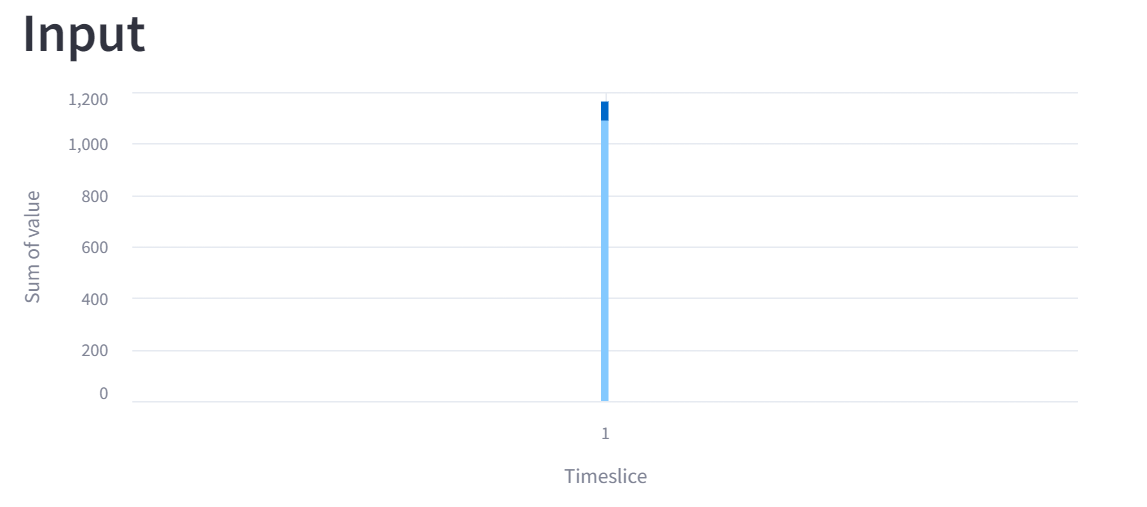

### DAC operation
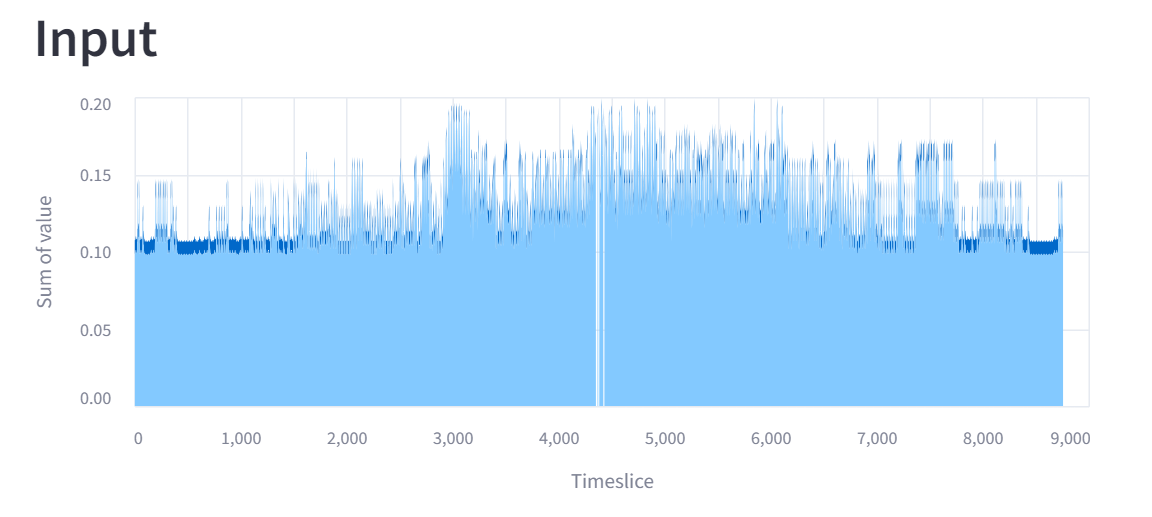

